In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!ls faster_rcnn_resnet101_coco_11_06_2017

frozen_inference_graph.pb


In [3]:
SSD_GRAPH_FILE = 'faster_rcnn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'

In [4]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

In [5]:
detection_graph = load_graph(SSD_GRAPH_FILE)

image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

In [6]:
def detect(image, sess):
    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
    
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)
    
    return boxes, scores, classes

In [28]:
def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score and classes[i]==10:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    '''draws bounding boxes'''
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (bbox[1], bbox[0]),(bbox[3], bbox[2]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def sub_images(im,box_coords):
    '''grab a rectangular area from a larger image'''
    images=[]
    for b in box_coords:
        x,y,w,h = int(np.round(b[1])),int(np.round(b[0])),int(np.round(b[3]-b[1])),int(np.round(b[2]-b[0]))
        images.append(im[y:y+h, x:x+w])
    return images

def classify_sub(sub):
    '''classify an image that contains ONLY a traffic light (we assume)
    simple R,G, and yellow-ish thresholding at the assumed positions: Green at the bottom, red at the top
    '''
    h,w, _ = sub.shape
    h3 = int(h/3)
    light_color=[]

    #maybe green? check the lower third of the image's green channel
    i=0
    a= h-i*h3
    b = h-(i+1)*h3
    ret,thresh = cv2.threshold(sub[b:a,:,1],190,255,cv2.THRESH_BINARY)
    #plt.imshow(thresh,cmap='gray')

    light_color.append(thresh.mean())

    #maybe yellow? check the middle
    #plt.figure()

    i=1
    a= h-i*h3
    b = h-(i+1)*h3
    lower = np.uint8([180, 180,   0])
    upper = np.uint8([255, 255, 255])
    thresh = cv2.inRange(sub[b:a,:,:], lower, upper)
    #plt.imshow(thresh,cmap='gray')

    light_color.append(thresh.mean())

    #maybe red? check the top part of the image for red
    #plt.figure()
    i=2
    a= h-i*h3
    b = h-(i+1)*h3
    ret,thresh = cv2.threshold(sub[b:a,:,0],127,255,cv2.THRESH_BINARY)
    #plt.imshow(thresh,cmap='gray')

    light_color.append(thresh.mean())

    print(light_color)
    light_states={0:'GREEN',1:'YELLOW',2:'RED'}
    
    if np.max(light_color) < 25:
        return 'UNKNOWN'
    
    return light_states[np.argmax(light_color)]

def classify_all(im,sess):
    '''do everything'''
    boxes, scores, classes = detect(im,sess)
    boxes, scores, classes = filter_boxes(.75, boxes, scores, classes)
    h, w, _ = im.shape
    box_coords = to_image_coords(boxes, h, w)
    subs = sub_images(im, box_coords)
    
    plt.imshow(draw_boxes(im,box_coords))
    return [classify_sub(sub) for sub in subs]

In [23]:
sess = tf.Session(graph=detection_graph)

In [24]:
red= cv2.imread('data/red.jpg')
red = cv2.cvtColor(red, cv2.COLOR_BGR2RGB)

green= cv2.imread('data/green.jpg')
green = cv2.cvtColor(green, cv2.COLOR_BGR2RGB)

yellow= cv2.imread('data/yellow.jpg')
yellow = cv2.cvtColor(yellow, cv2.COLOR_BGR2RGB)

[0.9916666666666667, 0.0, 72.108333333333334]
[7.9054054054054053, 0.067567567567567571, 89.054054054054049]
[1.2460477148605922, 0.0, 60.983041103765451]


['RED', 'RED', 'RED']

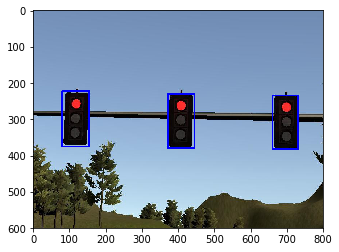

In [31]:
classify_all(red,sess)

[57.530487804878049, 0.10365853658536585, 19.695121951219512]
[41.028717545239971, 0.30094413847364282, 28.690007867820615]
[44.053156146179404, 0.18826135105204872, 31.439645625692137]


['GREEN', 'GREEN', 'GREEN']

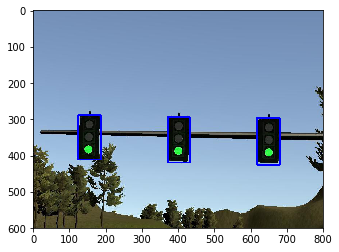

In [30]:
classify_all(green,sess)

[9.3419267299864313, 37.713704206241516, 25.257801899592945]
[2.9641025641025642, 38.358974358974358, 12.728205128205127]
[2.8157349896480333, 39.33229813664596, 22.349896480331264]


['YELLOW', 'YELLOW', 'YELLOW']

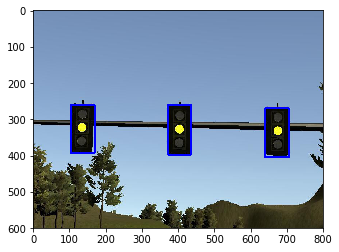

In [29]:
classify_all(yellow,sess)